In [0]:
# This notebook does the following:

# 1. Extract the SUBJECT_IDs for whom a record edxists in the MIMIC matched waveform dataset (total number 4,653) from a 'df_waveform_exists.csv' CSV file into a dataframe

# 2. Extract all the unique signals that are recorded for above patients and generate a 'physio_signals.txt' file.

# 3. Check for which SUBJECT_IDs there exists all relevant signals i.e. HR, SPO2%, ABP SYS, ABP DIAS, ABP MEAN, and RESP. If there exists all signals
#    insert '1' in the 'sig_exists' column for that particular patient in the dataframe.

# 4. Considering the SUBJECT_IDs for which there exists all relevant signals in the database, 
#    check if the recordings in the database overlap with their ICU stays i.e. check if there is a overlap between the recording start date and end date 
#    and ICU intime and outtime. If there exists a overlap, insert '1' in the 'timeoverlap' column for that particular patient in the dataframe.

# 5. Generate a final CSV 'df_TS_exists_withoutTEMP_overlapcount.csv'

# 6. There are a few sample records, 1 for once per second sampling frequency and 1 for once per minute frequency. Each of these are read from the
#    matched waveform database and we extract only required HR, SPO2%, ABP SYS, ABP DIAS, ABP MEAN,& RESP signals and insert it into a dataframe. For sample
#    with onec per second sampling frequency, the data is converted to once per minute by calculating average for each 60 secs.



In [2]:
!pip install wfdb
import io
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
import urllib.request
import datetime

     |████████████████████████████████| 112kB 8.3MB/s 
     |████████████████████████████████| 6.6MB 14.4MB/s 
     |████████████████████████████████| 163kB 54.4MB/s 


In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
df_csvdata = pd.read_csv(io.BytesIO(uploaded['df_waveform_exists.csv']))
# Dataset is now stored in a Pandas Dataframe
print (df_csvdata.shape)
df_csvdata['sig_exists']='';
df_csvdata['timeoverlap']='';
df_csvdata['Number_of_overlaping_records'] =''

print (df_csvdata.shape)



In [0]:
#To get a list of all the unique signals present in PHYSIOBANK

from collections import namedtuple
for index, row in df_csvdata.iterrows():
    #print(row['subject_id'], row['icustay_id'], row['sepsis_onsettime'],row['intime'],row['outtime'])
    signals_in_pyhisobank=[]
    wdb_dir_path = 'mimic3wdb/matched/p'+ str(row['subject_id']).zfill(6)[:2] + '/p' + str(row['subject_id']).zfill(6) + '/';
    wdb_path_toAllRecords = 'https://archive.physionet.org/physiobank/database/'+ wdb_dir_path + 'RECORDS';
    wdb_records =  urllib.request.urlopen(wdb_path_toAllRecords);    
    for lines in wdb_records.readlines():
      record = lines.decode("utf-8"); 
      record = str(record).rstrip()
      #print (record[-1:])
      if record[-1:] == 'n':
        #print(record);
        #print (wdb_dir_path);
        record = str(record).rstrip()

        try:
          print(row['subject_id'])
          signals,fields = wfdb.rdsamp(record, pb_dir=wdb_dir_path) ;                 
          for i in fields['sig_name']:
            if i not in signals_in_pyhisobank:
              signals_in_pyhisobank.append(i);
          
        except ValueError:
          print('Error occured while reading waveform: ', record);

"""
#testing date part
        
       

            
        Range = namedtuple('Range', ['start', 'end'])

        print ('intime :', datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') ); 
               
        print ('outtime :', datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S') ); 

        print ('record starttime' , record_starttime);

        print ('record endtime' , record_endtime);

        r1 = Range(start= datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S'), end= datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S'))
        r2 = Range(start= record_starttime, end = record_endtime)
        latest_start = max(r1.start, r2.start)
        earliest_end = min(r1.end, r2.end)
        delta = (earliest_end - latest_start).days + 1
        if delta > 0 :
          print('NO OVERLAP BETWEEN RECORD DATETIME AND ICU STAY DATETIME')
          df_csvdata['TS_exists'] = 1;

        #overlap = max(0, delta) #to find exact overlap days
"""

print(len(signals_in_pyhisobank))
with open("physio_signals.txt", "w") as output:
    output.write(str(signals_in_pyhisobank))

from google.colab import files
files.download('physio_signals.txt')


In [0]:
#### IMPORTANT ! DO NOT DELETE
#To get patients for whom required signals exists and there are TS records for the ICU stay in consideration

from collections import namedtuple
for index, row in df_csvdata.iterrows():
    #print(row['subject_id'], row['icustay_id'], row['sepsis_onsettime'],row['intime'],row['outtime'])
    records_toRead=[]
    wdb_dir_path = 'mimic3wdb/matched/p'+ str(row['subject_id']).zfill(6)[:2] + '/p' + str(row['subject_id']).zfill(6) + '/';
    wdb_path_toAllRecords = 'https://archive.physionet.org/physiobank/database/'+ wdb_dir_path + 'RECORDS';
    wdb_records =  urllib.request.urlopen(wdb_path_toAllRecords);   
    count_overlaping_records = 0 
    for lines in wdb_records.readlines():
      record = lines.decode("utf-8"); 
      record = str(record).rstrip()
      #print (record[-1:])
      if record[-1:] == 'n':
        #print(record);
        #print (wdb_dir_path);
        record = str(record).rstrip()

        try:
          signals,fields = wfdb.rdsamp(record, pn_dir=wdb_dir_path) ; 
          #wfdb.plot_items(signal=signals, fs=fields['fs'])
          #display(signals)
          #display(fields)
          #print ('fs' , fields['fs']);
          #print ('signal length',fields['sig_len']);
          #print ('date' ,fields['base_date'] );        
          #print ('time' ,fields['base_time'] );
          #print ('%.3f'%(fields['fs']))
          
          list_sig_name = [item.upper().replace(' ','') for item in fields['sig_name']]

          sig_exist_1 = all(x in list_sig_name for x in ['HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP']);  #%SpO2
          sig_exist_2 = all(x in list_sig_name for x in ['HR', '%SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP']); 

          if ((sig_exist_1 == True) or (sig_exist_2 == True)) :

            df_csvdata.loc[index,'sig_exists'] = 1;
            record_starttime = datetime.datetime.combine(fields['base_date'] ,fields['base_time'] ) ;
            
            if  '%.3f'%(fields['fs']) == '1.000' :
              record_endtime = record_starttime + datetime.timedelta(seconds= (fields['sig_len']-1)) ;
            elif '%.3f'%(fields['fs'])== '0.017' :
              record_endtime = record_starttime + datetime.timedelta(minutes = (fields['sig_len']-1)) ;
            else : 
              print('ERROR IN SAMPLING');
              print(record);
              print (wdb_dir_path);

            #Caculate if we have a recording for the time of icu stay
            Range = namedtuple('Range', ['start', 'end'])

            r1 = Range(start= datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S'), end= datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S'))
            r2 = Range(start= record_starttime, end = record_endtime)
            latest_start = max(r1.start, r2.start)
            earliest_end = min(r1.end, r2.end)
            delta = (earliest_end - latest_start).days + 1
            if delta >= 0 :
              print('RECORD EXISTS FOR THE ICU STAYS WITH THE SIGNALS NEEDED : ', row['subject_id'])
              df_csvdata.loc[index,'timeoverlap'] = 1;
              count_overlaping_records = count_overlaping_records +1 ;

              #todo : adding new dataframe, exatracting required signals, computing avergage for per sminute values in case of per second sampling frequency

            else:            
              print('RECORD DOES NOT EXISTS FOR THE ICU STAYS WITH THE SIGNALS NEEDED : ', row['subject_id'])
              #df_csvdata.loc[index,'timeoverlap'] = 0;

          else:
            #df_csvdata.loc[index,'sig_exists'] =  0 ;
            print('DO NOT SELECT THIS RECORD', row['subject_id'])
        except ValueError:
          print('Error occured while reading waveform: ', record);

    df_csvdata.loc[index,'Number_of_overlaping_records'] = count_overlaping_records;

"""
#testing date part
        
       

            
        Range = namedtuple('Range', ['start', 'end'])

        print ('intime :', datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') ); 
               
        print ('outtime :', datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S') ); 

        print ('record starttime' , record_starttime);

        print ('record endtime' , record_endtime);

        r1 = Range(start= datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S'), end= datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S'))
        r2 = Range(start= record_starttime, end = record_endtime)
        latest_start = max(r1.start, r2.start)
        earliest_end = min(r1.end, r2.end)
        delta = (earliest_end - latest_start).days + 1
        if delta > 0 :
          print('NO OVERLAP BETWEEN RECORD DATETIME AND ICU STAY DATETIME')
          df_csvdata['TS_exists'] = 1;

        #overlap = max(0, delta) #to find exact overlap days
"""

# check dataframe 

print(df_csvdata[(df_csvdata['sig_exists'] == 1)].shape)
print(df_csvdata[(df_csvdata['timeoverlap'] == 1)].shape)

df_csvdata.to_csv ('df_TS_exists_withoutTEMP_overlapcount.csv', sep=',', index = False, header=True);

from google.colab import files
files.download('df_TS_exists_withoutTEMP_overlapcount.csv')


In [0]:
#example to send to Marcela
!pip install wfdb
import io
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
import urllib.request
import datetime
"""
'HR',
  'PULSE', 
  'ABP SYS',
  'ABP DIAS',
"""
channels = ['ABP DIAS','ABP SYS','PULSE','temp','HR']
signals,fields = wfdb.rdsamp('p042930-2190-07-28-20-30n', pn_dir='mimic3wdb/matched/p04/p042930/')
wfdb.plot_items(signal=signals, fs=fields['fs'])
display(signals)
display(fields)
print ('fs' , fields['fs']);
print ('signal length',fields['sig_len']);
print ('date' ,fields['base_date'] );        
print ('time' ,fields['base_time'] );
record_starttime = datetime.datetime.combine(fields['base_date'] ,fields['base_time'] ) ;
print ('%.3f'%(fields['fs']))
if  '%.3f'%(fields['fs']) == '1.000':
  print ('Sampled once per second')
  record_endtime = record_starttime + datetime.timedelta(seconds = (fields['sig_len']-1)) ;
elif '%.3f'%(fields['fs'])== '0.017' :
  print('Sampled once per minute')
  record_endtime = record_starttime + datetime.timedelta(minutes = (fields['sig_len']-1)) ;
else :
  print('ERROR IN SAMPLING')  


In [0]:
#### To show a sample of person suffereing from sepsis with high values for  ABP Systolic (90 and less than 120) and low values for ABP diastolic (60 and less than 80)


# SAMPLE FREQUENCY: ONCE PER SECOND


#for i in subject_ids:
 # print (i.zfill(6)); --2186-01-26 14:13:07
!pip install wfdb
import io
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
import urllib.request
import datetime



signals,fields = wfdb.rdsamp('p081193-2186-01-26-19-36n', pn_dir='mimic3wdb/matched/p08/p081193/', sampfrom = 0 , sampto = 120)#sampfrom = 150 , sampto = 200

wfdb.plot_items(signal=signals, fs=fields['fs'])
#display(record.__dict__)

display(signals)
display(fields)

df_ts_records_columns = ['RECORD','TIME','HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP'] 


df_ts_records = pd.DataFrame(columns=df_ts_records_columns);
for i in fields['sig_name']:
  if i.upper().replace(' ','') == 'HR':
    idx_HR = fields['sig_name'].index(i);
    df_ts_records['HR']= signals[:,idx_HR ]

  elif (( i.upper().replace(' ','') == 'SPO2') or (i.upper().replace(' ','') =='%SPO2')):
    idx_SPO2 = fields['sig_name'].index(i);
    df_ts_records['SPO2']= signals[:,idx_SPO2]

  elif i.upper().replace(' ','') == 'ABPSYS' :
    idx_ABPSYS = fields['sig_name'].index(i);
    df_ts_records['ABPSYS']= signals[:,idx_ABPSYS]

  elif i.upper().replace(' ','') == 'ABPDIAS' :
    idx_ABPDIAS = fields['sig_name'].index(i);
    df_ts_records['ABPDIAS']= signals[:,idx_ABPDIAS]

  elif i.upper().replace(' ','') == 'ABPMEAN' :
    idx_ABPMEAN = fields['sig_name'].index(i);
    df_ts_records['ABPMEAN']= signals[:,idx_ABPMEAN]
  
  elif i.upper().replace(' ','') == 'RESP' :
    idx_RESP = fields['sig_name'].index(i);
    df_ts_records['RESP']= signals[:,idx_RESP]
  
record_starttime = datetime.datetime.combine(fields['base_date'] ,fields['base_time'] ) ;

if  '%.3f'%(fields['fs']) == '1.000' :
  print ('Sampled once per second')
  record_endtime = record_starttime + datetime.timedelta(seconds = (fields['sig_len']-1)) ;
elif '%.3f'%(fields['fs'])== '0.017' :
  print('Sampled once per minute')
  record_endtime = record_starttime + datetime.timedelta(minutes = (fields['sig_len']-1)) ;
else :
  print('ERROR IN SAMPLING')  

print ('start time: ', record_starttime);
print ('end time: ', record_endtime);

df_ts_records['TIME'] = pd.date_range( record_starttime , periods = fields['sig_len'], freq='S'); 
df_ts_records.TIME = pd.to_datetime(df_ts_records.TIME)
#dat['STA_STD_NEW'] = dat['STA_STD']

#dat.loc[dat['STA_STD'].dt.time == datetime.time(23,59), 'STA_STD_NEW'] += datetime.timedelta(minutes=1)

#In [5]: dat
df_ts_records['RECORD'] = 'p081193-2186-01-26-19-36n';
print(df_ts_records)


# to aggregate and convert per second values into per minute values
start_idx = 0;

df_ts_records_columns_new = ['RECORD','TIME','HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP'] 


df_ts_records_new = pd.DataFrame(columns=df_ts_records_columns_new);

print('length of new df  '  ,df_ts_records_new.shape[0] )

for index, rows in df_ts_records.iterrows():
  if start_idx >= df_ts_records.shape[0]:
    exit;
  else: 
    #print(df_ts_records.iloc[start_idx: (start_idx+2), 0:4])
    print(df_ts_records.iloc[start_idx: (start_idx+60), 2:8])
    array = np.array( df_ts_records.iloc[start_idx: (start_idx+60), 2:8].mean(axis=0))
    print('printing array of average')
    print (array)

    current_index = df_ts_records_new.shape[0]
    df_ts_records_new.loc[current_index ,'HR']= array[0]
    df_ts_records_new.loc[current_index,'SPO2']= array[1]
    df_ts_records_new.loc[current_index,'ABPSYS']= array[2]
    df_ts_records_new.loc[current_index,'ABPDIAS']= array[3]
    df_ts_records_new.loc[current_index,'ABPMEAN']= array[4]
    df_ts_records_new.loc[current_index,'RESP']= array[5]

    print(df_ts_records_new)
    print('next average')
    start_idx = start_idx+60;
    #print('start index :: ' , start_idx)

df_ts_records_new['TIME'] = pd.date_range(record_starttime, periods=(fields['sig_len']/60), freq='1min'); 
df_ts_records_new.TIME = pd.to_datetime(df_ts_records_new.TIME)
df_ts_records_new['RECORD'] = 'p081193-2186-01-26-19-36n';

print(df_ts_records_new)
  



In [0]:
# testing to convert per second data into per minute
"""
#df.iloc[1:3, 0:3]
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},
          {'a': 100, 'b': 200, 'c': 300, 'd': 400},
          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 },
          {'a': 10, 'b': 30, 'c': 50, 'd': 70 },
          {'a': 20, 'b': 40, 'c': 60, 'd': 80 },
          {'a': 20, 'b': 40, 'c': 60, 'd': 80 },
          {'a': 20, 'b': 40, 'c': 60, 'd': 80 },
          {'a': 20, 'b': 40, 'c': 60, 'd': 80 },
          {'a': 20, 'b': 40, 'c': 60, 'd': 80 }
          ]
import numpy as np
df = pd.DataFrame(mydict)
print (df)
"""
"""
print(df.shape)
print('-----')
print(df.iloc[0:2, 0:4])
dd = pd.DataFrame( df.iloc[0:2, 0:4].mean(axis =0))
print(dd)
"""
"""
print('---------------------')
start_idx = 0 
new_df=pd.DataFrame(columns=['a','b','c','d']);
print(new_df)
print('length of new df  '  ,new_df.shape[0] )

for index, rows in df.iterrows():
  if start_idx > df.shape[0]:
    exit;
  else: 
    print(df.iloc[start_idx: (start_idx+2), 0:4])
    print(df.iloc[start_idx: (start_idx+2), 0:4].mean(axis=0))
    array = np.array( df.iloc[start_idx: (start_idx+2), 0:4].mean(axis=0))
    print (array)
    
    current_index = new_df.shape[0]
    new_df.loc[current_index ,'a']= array[0]
    new_df.loc[current_index,'b']= array[1]
    new_df.loc[current_index,'c']= array[2]
    new_df.loc[current_index,'d']= array[3]
    print(new_df)
    print('next average')
    start_idx = start_idx+2;
    print('start index :: ' , start_idx)

  

"""



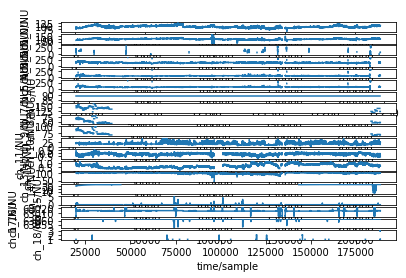

array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [  108.,   105.,    nan, ..., 63015., 63062.,    nan],
       [  108.,   105.,    nan, ..., 63015., 63062.,    nan],
       [  108.,   105.,    nan, ..., 63015., 63062.,    nan]])

(218177, 19)


{'base_date': datetime.date(2173, 5, 16),
 'base_time': datetime.time(11, 56, 37, 591000),
 'comments': ['Location: sicu'],
 'fs': 1,
 'n_sig': 19,
 'sig_len': 218177,
 'sig_name': ['HR',
  'PULSE',
  'ABP',
  'ABP Sys',
  'ABP Dias',
  'ABP Mean',
  'NBP',
  'NBP Sys',
  'NBP Dias',
  'NBP Mean',
  'RESP',
  'ST III',
  'ST V',
  'SpO2',
  'Temp Rect',
  'PVC Rate per Minute',
  'Rhythm Status',
  'Ectopic Status',
  'Ectopic Count'],
 'units': ['bpm',
  'bpm',
  'mmHg',
  'mmHg',
  'mmHg',
  'mmHg',
  'mmHg',
  'mmHg',
  'mmHg',
  'mmHg',
  'pm',
  'uV',
  'uV',
  '%',
  '?',
  'pm',
  '?',
  '?',
  '?']}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
#### To show a sample of person NOT suffereing from sepsis 
##############################
################################
#for i in subject_ids:
 # print (i.zfill(6)); --2186-01-26 14:13:07

 
 
 # SAMPLE FREQUENCY: ONCE PER MINUTE

df_ts_records_columns = ['RECORD','TIME','HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP','TEMP'] 

sig_list_1 = ['HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP','TEMP'] 
sig_list_2 = ['HR', '%SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP','TEMP']

df_ts_records = pd.DataFrame(columns=df_ts_records_columns);

signals, fields = wfdb.rdsamp('p059864-2173-05-16-11-56n', pn_dir ='mimic3wdb/matched/p05/p059864/')

# signals, fields = wfdb.rdsamp('p042930-2190-07-28-20-30n', pn_dir='mimic3wdb/matched/p04/p042930/',sampfrom=0, sampto=10)
wfdb.plot_items(signal=signals, fs=fields['fs'])


display(signals)
print( signals.shape) ;
display(fields)

for i in fields['sig_name']:
  if i.upper().replace(' ','') == 'HR':
    idx_HR = fields['sig_name'].index(i);
    df_ts_records['HR']= signals[:,idx_HR ]

  elif (( i.upper().replace(' ','') == 'SPO2') or (i.upper().replace(' ','') =='%SPO2')):
    idx_SPO2 = fields['sig_name'].index(i);
    df_ts_records['SPO2']= signals[:,idx_SPO2]

  elif i.upper().replace(' ','') == 'ABPSYS' :
    idx_ABPSYS = fields['sig_name'].index(i);
    df_ts_records['ABPSYS']= signals[:,idx_ABPSYS]

  elif i.upper().replace(' ','') == 'ABPDIAS' :
    idx_ABPDIAS = fields['sig_name'].index(i);
    df_ts_records['ABPDIAS']= signals[:,idx_ABPDIAS]

  elif i.upper().replace(' ','') == 'ABPMEAN' :
    idx_ABPMEAN = fields['sig_name'].index(i);
    df_ts_records['ABPMEAN']= signals[:,idx_ABPMEAN]
  
  elif i.upper().replace(' ','') == 'RESP' :
    idx_RESP = fields['sig_name'].index(i);
    df_ts_records['RESP']= signals[:,idx_RESP]

  elif i.upper().replace(' ','') == 'TEMP':
    idx_TEMP = fields['sig_name'].index(i);
    df_ts_records['TEMP']= signals[:,idx_TEMP ]

  

print(df_ts_records);

record_starttime = datetime.datetime.combine(fields['base_date'] ,fields['base_time'] ) ;

if  '%.3f'%(fields['fs']) == '1.000' :
  print ('Sampled once per second')
  record_endtime = record_starttime + datetime.timedelta(seconds = ( fields['sig_len']-1 )) ;
elif '%.3f'%(fields['fs'])== '0.017' :
  print('Sampled once per minute')
  record_endtime = record_starttime + datetime.timedelta(minutes = ( fields['sig_len']-1 )) ;
else :
  print('ERROR IN SAMPLING')  

print ('start time: ', record_starttime);
print ('end time: ', record_endtime);

df_ts_records['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='1min'); 
df_ts_records.TIME = pd.to_datetime(df_ts_records.TIME)

df_ts_records['RECORD'] = 'p042930-2190-07-28-20-30n';

#print('--------#####-----')
#print(df_ts_records[ (df_ts_records['TIME'] >= '2151-10-06 05:25:35') & (df_ts_records['TIME'] <= '2151-10-06 05:29:35')])
#print('dropping all null')
#print(df_ts_records.dropna())

In [5]:
#### IMPORTANT ! DO NOT DELETE
#To get patient records if multiple ts existis 


from collections import namedtuple

df_ts_records_columns = ['RECORD','TIME','HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP'] 
df_ts_records = pd.DataFrame(columns=df_ts_records_columns); # usbject_id level
"""
subject_id= 48149;
#subject_id= 24810;


#icu_outtime = datetime.datetime(2183, 1, 13, 17, 24,54)

icu_intime = datetime.datetime(2127, 5, 25, 8, 0,39)
icu_outtime = datetime.datetime(2127, 6, 16, 1, 15,22)

#icu_intime = datetime.datetime(2183, 1, 9, 3, 30,55)

print ('icu intime =', icu_intime)
print ('icu outtime', icu_outtime)
"""
subject_id= 59864;

icu_intime = datetime.datetime(2173, 5, 16, 12, 14,45)
print ('icu intime =', icu_intime)

icu_outtime = datetime.datetime(2173, 6, 8, 15, 45,23)
print ('icu outtime', icu_outtime)

#2173-05-16 12:14:45,2173-06-08 15:45:23,

wdb_dir_path = 'mimic3wdb/matched/p'+ str(subject_id).zfill(6)[:2] + '/p' + str(subject_id).zfill(6) + '/';
wdb_path_toAllRecords = 'https://archive.physionet.org/physiobank/database/'+ wdb_dir_path + 'RECORDS';
wdb_records =  urllib.request.urlopen(wdb_path_toAllRecords);  
count_overlap = 0; 
for lines in wdb_records.readlines():
    record = lines.decode("utf-8"); 
    record = str(record).rstrip()
    #print (record[-1:])
    if record[-1:] == 'n':
      print(record);
      #print (wdb_dir_path);
      record = str(record).rstrip()
      
      
      #try:
      signals =''
      fields = ''
      signals,fields = wfdb.rdsamp(record, pn_dir=wdb_dir_path) ; 
        
      list_sig_name = [item.upper().replace(' ','') for item in fields['sig_name']]

      sig_exist_1 = all(x in list_sig_name for x in ['HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP']);  #%SpO2
      sig_exist_2 = all(x in list_sig_name for x in ['HR', '%SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP']); 

      record_starttime = datetime.datetime.combine(fields['base_date'] ,fields['base_time'] ) ;
            
      if  '%.3f'%(fields['fs']) == '1.000' :
        record_endtime = record_starttime + datetime.timedelta(seconds= (fields['sig_len']-1)) ;
      elif '%.3f'%(fields['fs'])== '0.017' :
        record_endtime = record_starttime + datetime.timedelta(minutes = (fields['sig_len']-1)) ;
      else : 
        print('ERROR IN SAMPLING');
        print(record);
        print(wdb_dir_path);

      print('record START time:  ', record_starttime)
      print('record END time:  ', record_endtime)
      Range = namedtuple('Range', ['start', 'end'])
      r1 = Range(start= icu_intime, end= icu_outtime)
      r2 = Range(start= record_starttime, end = record_endtime)
      latest_start = max(r1.start, r2.start)
      earliest_end = min(r1.end, r2.end)
      delta = (earliest_end - latest_start).days + 1
       #delta >= 0 :

      if ( ((sig_exist_1 == True) or (sig_exist_2 == True)) and (delta >= 0)):
        ###
        try:
          df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True)
        except:
          print('individual record for a single patient df does not exists')
          
        df_ts_indv_record_temp = pd.DataFrame(columns = df_ts_records_columns ) # individual record for a single patient #safiya
        ###

        df_row_idx = df_ts_records.shape[0] ;
        print('length of signal: ', len(signals))
        print('index of dataframe before inserting into it: ', df_row_idx)
         
        for i in fields['sig_name']:
          
          if i.upper().replace(' ','') == 'HR':
            idx_HR = fields['sig_name'].index(i);
          elif (( i.upper().replace(' ','') == 'SPO2') or (i.upper().replace(' ','') =='%SPO2')):
            idx_SPO2 = fields['sig_name'].index(i);
          elif i.upper().replace(' ','') == 'ABPSYS' :
            idx_ABPSYS = fields['sig_name'].index(i);
          elif i.upper().replace(' ','') == 'ABPDIAS' :
            idx_ABPDIAS = fields['sig_name'].index(i);
          elif i.upper().replace(' ','') == 'ABPMEAN' :
            idx_ABPMEAN = fields['sig_name'].index(i);
          elif i.upper().replace(' ','') == 'RESP' :
            idx_RESP = fields['sig_name'].index(i);
            
        
        
        if count_overlap == 0 : 
            if record_starttime > icu_intime:
              print('inserting nulls before the record start time')
              minutes_to_insert_start = record_starttime - icu_intime
              print('minutes_to_insert_start:  ', minutes_to_insert_start)
              duration_in_s = minutes_to_insert_start.total_seconds()
              minutes_to_insert_start = divmod(duration_in_s, 60)[0] - 1 

              try:
                df_ts_records_time_temp_start.drop(df_ts_records_time_temp_start.index,  inplace=True)
              except :
                print( 'df_ts_records_time_temp_start does not exist')
              

              df_ts_records_time_temp_start = pd.DataFrame(columns=df_ts_records_columns)

              if '%.3f'%(fields['fs'])== '0.017' :
                df_ts_records_time_temp_start['TIME'] = pd.date_range(icu_intime + datetime.timedelta(minutes=1), 
                                                              periods=minutes_to_insert_start, freq='1min'); 

              elif '%.3f'%(fields['fs'])== '1.000' :
                df_ts_records_time_temp_start['TIME'] = pd.date_range(icu_intime + datetime.timedelta(seconds=1), 
                                                              periods= (duration_in_s-1), freq='S'); 

              print ('INSERTING ONLY NULL IN START:')
              print (df_ts_records_time_temp_start)
              df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_time_temp_start, ignore_index=True);
              print('inserting nulls in start IN INDV LEVEL')
              print(df_ts_indv_record_temp)




            try:
              df_ts_records_temp.drop(df_ts_records_temp.index,  inplace=True)
            except:
              print( 'df_ts_records_temp does not exist')

            df_ts_records_temp = pd.DataFrame(columns=df_ts_records_columns)
            df_ts_records_temp['HR']= signals[:,idx_HR ] 
            df_ts_records_temp['SPO2']= signals[:,idx_SPO2 ] 
            df_ts_records_temp['ABPSYS']= signals[:,idx_ABPSYS ] 
            df_ts_records_temp['ABPDIAS']= signals[:,idx_ABPDIAS ] 
            df_ts_records_temp['ABPMEAN']= signals[:,idx_ABPMEAN ] 
            df_ts_records_temp['RESP']= signals[:,idx_RESP ] 


            if '%.3f'%(fields['fs'])== '0.017' :
              df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='1min'); 
            elif '%.3f'%(fields['fs'])== '1.000' :
              df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='S'); 

            df_ts_records_temp.TIME = pd.to_datetime(df_ts_records_temp.TIME)
            df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_temp, ignore_index=True); #safiya

            print('inserting nulls in start + first record data')
            print(df_ts_indv_record_temp)

            if '%.3f'%(fields['fs'])== '1.000' : #safiya
              print("AGGREGATING")
              start_idx = 0;
              df_ts_records_new = pd.DataFrame(columns=df_ts_records_columns);
              #print('length of new df  '  , df_ts_records_new.shape[0] )
              for index, rows in df_ts_indv_record_temp.iterrows():
                print('start index for first: ', start_idx)
                if start_idx >= df_ts_indv_record_temp.shape[0]:
                  exit;
                else: 
                  
                  #print(df_ts_records.iloc[start_idx: (start_idx+60), 2:8])
                  array = np.array( df_ts_indv_record_temp.iloc[start_idx: (start_idx+60), 2:8].mean(axis=0))
                  #print('printing array of average')
                  #print (array)

                  current_index = df_ts_records_new.shape[0]
                  df_ts_records_new.loc[current_index ,'HR']= array[0]
                  df_ts_records_new.loc[current_index,'SPO2']= array[1]
                  df_ts_records_new.loc[current_index,'ABPSYS']= array[2]
                  df_ts_records_new.loc[current_index,'ABPDIAS']= array[3]
                  df_ts_records_new.loc[current_index,'ABPMEAN']= array[4]
                  df_ts_records_new.loc[current_index,'RESP']= array[5]

                  #print(df_ts_records_new)
                  #print('next average')
                  start_idx = start_idx+60;
                  #print('start index :: ' , start_idx)

              print('# record time:  ',df_ts_records_new.shape[0])
              df_ts_records_new['TIME'] = pd.date_range(df_ts_indv_record_temp.loc[0,'TIME'], periods= df_ts_records_new.shape[0], freq='1min'); 
              df_ts_records_new.TIME = pd.to_datetime(df_ts_records_new.TIME)
              #print(df_ts_records_new)

              df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True);
              #df_ts_records = pd.DataFrame(columns=df_ts_records_columns)
              df_ts_records = df_ts_records.append(df_ts_records_new, ignore_index=True);
              print('only first record  aggregated at individual record level: ')
              print(df_ts_records_new)
              print('inserting aggregated first record into  FINAL SUBJEC DATAFRAME')
              print(df_ts_records)
              df_ts_records_new.drop(df_ts_records_new.index, inplace=True)
              df_ts_records['RECORD'] = record   

            else:
              df_ts_records = df_ts_records.append(df_ts_indv_record_temp, ignore_index=True);
              df_ts_records['RECORD'] = record   

              print('inserting nulls in start + first record data into FINAL SUBJEC DATAFRAME')
              print(df_ts_records)
           
               
        else:
            if record_starttime <= icu_outtime :
              last_Record_time = df_ts_records.loc[(df_row_idx-1),'TIME']
              print('main DF last time record: ',last_Record_time )
              minutes_to_insert = record_starttime - last_Record_time
              duration_in_s = minutes_to_insert.total_seconds()
              minutes_to_insert = divmod(duration_in_s, 60)[0] - 1

              print ('minutes_to_insert:  ', minutes_to_insert);
              print('seconds to insert: ', duration_in_s)


              try:
                df_ts_records_time_temp.drop(df_ts_records_time_temp.index, inplace=True);
                df_ts_records_temp.drop(df_ts_records_temp.index, inplace=True);
              except:
                print ('df_ts_records_temp and df_ts_records_time_temp does not exits')

              df_ts_records_time_temp = pd.DataFrame(columns=df_ts_records_columns)
              if '%.3f'%(fields['fs'])== '0.017' :
                df_ts_records_time_temp['TIME'] = pd.date_range(last_Record_time + datetime.timedelta(minutes=1), 
                                                              periods=minutes_to_insert, freq='1min'); 
              elif  '%.3f'%(fields['fs'])== '1.000' :
                print('last record time' , last_Record_time)
                print('(duration_in_s-1)' , (duration_in_s-1))
                df_ts_records_time_temp['TIME'] = pd.date_range(last_Record_time + datetime.timedelta(seconds=1), 
                                                              periods=(duration_in_s-1), freq='S'); 
              print ('INSERTING ONLY NULL UNTILL NEXT RECORD START TIME:')
              print (df_ts_records_time_temp)

              df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_time_temp, ignore_index=True);
              print('inserting nulls UNTILL NEXT RECORD START TIME INTO INDV LEVEL')
              print(df_ts_indv_record_temp)

              df_ts_records_temp = pd.DataFrame(columns=df_ts_records_columns)
          
              df_ts_records_temp['HR']= signals[:,idx_HR ] 
              df_ts_records_temp['SPO2']= signals[:,idx_SPO2 ] 
              df_ts_records_temp['ABPSYS']= signals[:,idx_ABPSYS ] 
              df_ts_records_temp['ABPDIAS']= signals[:,idx_ABPDIAS ] 
              df_ts_records_temp['ABPMEAN']= signals[:,idx_ABPMEAN ] 
              df_ts_records_temp['RESP']= signals[:,idx_RESP ] 
              if '%.3f'%(fields['fs'])== '0.017' :
                df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='1min'); 
              elif  '%.3f'%(fields['fs'])== '1.000' :
                df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='S'); 

              df_ts_records_temp.TIME = pd.to_datetime(df_ts_records_temp.TIME)
            
              print('before appending: ')
            
              print( df_ts_records_temp);
              df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_temp, ignore_index=True);

              print('inserting nulls in start + SECOND record data')
              print(df_ts_indv_record_temp)

              if '%.3f'%(fields['fs'])== '1.000' : #safiya
                start_idx = 0;
                df_ts_records_new = pd.DataFrame(columns=df_ts_records_columns);
                #print('length of new df  '  , df_ts_records_new.shape[0] )
                for index, rows in df_ts_indv_record_temp.iterrows():
                  if start_idx >= df_ts_indv_record_temp.shape[0]:
                    exit;
                  else: 
                    
                    #print(df_ts_records.iloc[start_idx: (start_idx+60), 2:8])
                    array = np.array( df_ts_indv_record_temp.iloc[start_idx: (start_idx+60), 2:8].mean(axis=0))
                    #print('printing array of average')
                    #print (array)

                    current_index = df_ts_records_new.shape[0]
                    df_ts_records_new.loc[current_index ,'HR']= array[0]
                    df_ts_records_new.loc[current_index,'SPO2']= array[1]
                    df_ts_records_new.loc[current_index,'ABPSYS']= array[2]
                    df_ts_records_new.loc[current_index,'ABPDIAS']= array[3]
                    df_ts_records_new.loc[current_index,'ABPMEAN']= array[4]
                    df_ts_records_new.loc[current_index,'RESP']= array[5]

                    #print(df_ts_records_new)
                    #print('next average')
                    start_idx = start_idx+60;
                    #print('start index :: ' , start_idx)

                print('# record time:  ',df_ts_records_new.shape[0])
                df_ts_records_new['TIME'] = pd.date_range(df_ts_indv_record_temp.loc[0,'TIME'], periods= df_ts_records_new.shape[0], freq='1min'); 
                df_ts_records_new.TIME = pd.to_datetime(df_ts_records_new.TIME)
                #print(df_ts_records_new)

                df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True);
                #df_ts_records = pd.DataFrame(columns=df_ts_records_columns)
                df_ts_records = df_ts_records.append(df_ts_records_new, ignore_index=True);
                
                print('only first record  aggregated at individual record level: ')
                print(df_ts_records_new)
                print('inserting aggregated first record into  FINAL SUBJEC DATAFRAME')
                print(df_ts_records)
                df_ts_records_new.drop(df_ts_records_new.index, inplace=True)
                df_ts_records['RECORD'] = record   

              else:
                df_ts_records = df_ts_records.append(df_ts_indv_record_temp, ignore_index=True);
                df_ts_records['RECORD'] = record   
                print('inserting nulls in start + first record data into FINAL SUBJEC DATAFRAME')
                print(df_ts_records)
           
              
        count_overlap = count_overlap +1
        print('overlap count after all insertions: ', count_overlap )
      






Streaming output truncated to the last 5000 lines.
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for first:  218220
start index for fir

In [17]:
print(df_ts_records)

                          RECORD                TIME  ...  ABPMEAN     RESP
0      p045703-2168-02-10-14-36n 2168-02-01 01:26:33  ...      NaN      NaN
1      p045703-2168-02-10-14-36n 2168-02-01 01:27:33  ...      NaN      NaN
2      p045703-2168-02-10-14-36n 2168-02-01 01:28:33  ...      NaN      NaN
3      p045703-2168-02-10-14-36n 2168-02-01 01:29:33  ...      NaN      NaN
4      p045703-2168-02-10-14-36n 2168-02-01 01:30:33  ...      NaN      NaN
...                          ...                 ...  ...      ...      ...
23402  p045703-2168-02-10-14-36n 2168-02-17 07:23:38  ...  72.3667  23.2333
23403  p045703-2168-02-10-14-36n 2168-02-17 07:24:38  ...     72.3  22.2333
23404  p045703-2168-02-10-14-36n 2168-02-17 07:25:38  ...  73.8833  23.3167
23405  p045703-2168-02-10-14-36n 2168-02-17 07:26:38  ...       73  21.9667
23406  p045703-2168-02-10-14-36n 2168-02-17 07:27:38  ...  72.5769     21.5

[23407 rows x 8 columns]
